# Import Libraries

In [183]:
from doctr.io import DocumentFile
from doctr.models import ocr_predictor
import cv2

# Detect

In [184]:

model = ocr_predictor(det_arch='db_resnet50', reco_arch='crnn_vgg16_bn', pretrained=True,assume_straight_pages=False,detect_language=True, export_as_straight_boxes=True)

# Image path

In [185]:
image_path = "test_german.jpeg"

In [186]:
doc = DocumentFile.from_images(image_path) 


# Analyze

In [187]:
result = model(doc)

In [188]:
json_output= result.export()

In [189]:
lng = json_output['pages'][0]['language']['value']

# Output

In [190]:
ocr_data = json_output['pages'][0]['blocks'][0]
height,width = json_output['pages'][0]['dimensions']

In [191]:
import math

def boxes_are_close(box1, box2, min_distance_ratio, img_width, img_height):
    """
    Returns True if boxes touch, overlap, or are within a minimum distance.
    min_distance_ratio: fraction of image diagonal (e.g., 0.01 for 1%)
    """
    (x1a, y1a), (x2a, y2a) = box1
    (x1b, y1b), (x2b, y2b) = box2

    # Calculate minimum distance in pixels
    img_diagonal = math.sqrt(img_width**2 + img_height**2)
    min_distance = min_distance_ratio * img_diagonal

    # Check overlap
    if not (x2a < x1b or x2b < x1a or y2a < y1b or y2b < y1a):
        return True  # overlap or touch

    # Compute closest horizontal distance
    if x2a < x1b:
        dx = x1b - x2a
    elif x2b < x1a:
        dx = x1a - x2b
    else:
        dx = 0

    # Compute closest vertical distance
    if y2a < y1b:
        dy = y1b - y2a
    elif y2b < y1a:
        dy = y1a - y2b
    else:
        dy = 0

    # Euclidean distance between closest edges
    distance = math.sqrt(dx**2 + dy**2)
    return distance <= min_distance


In [192]:
results = []
min_distance_ratio = 0.01  # 1% of image diagonal; you can tweak this!

for line in ocr_data['lines']:
    for word in line['words']:
        word_text = word['value']
        (x1_norm, y1_norm), (x2_norm, y2_norm) = word['geometry']
        x1_abs, y1_abs = int(x1_norm * width), int(y1_norm * height)
        x2_abs, y2_abs = int(x2_norm * width), int(y2_norm * height)
        new_box = ((x1_abs, y1_abs), (x2_abs, y2_abs))

        placed = False
        for group in results:
            if boxes_are_close(group['box'], new_box, min_distance_ratio, width, height):
                # Merge with existing group
                group['text'] += ' ' + word_text
                (gx1, gy1), (gx2, gy2) = group['box']
                group['box'] = (
                    (min(gx1, x1_abs), min(gy1, y1_abs)),
                    (max(gx2, x2_abs), max(gy2, y2_abs))
                )
                placed = True
                break

        if not placed:
            results.append({
                'text': word_text,
                'box': new_box
            })


In [193]:
len(results)

15

# Read image and plot

In [194]:
import matplotlib.pyplot as plt

In [195]:
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_text = img_rgb.copy()

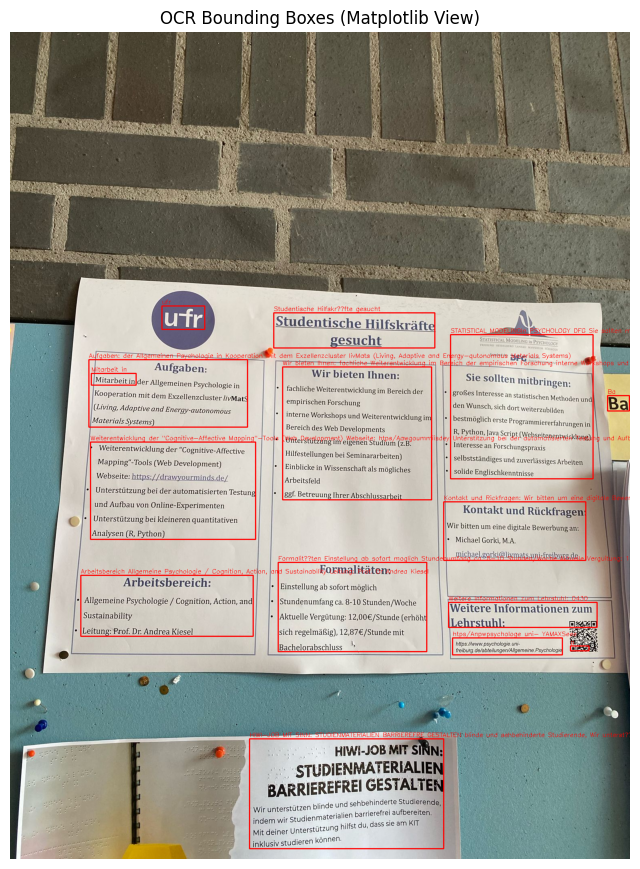

In [196]:
for res in results:
    (x1, y1), (x2, y2) = res['box']
    cv2.rectangle(img_text, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue in RGB
    cv2.putText(img_text, res['text'], (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

# Show using matplotlib
plt.figure(figsize=(8, 12))
plt.imshow(img_text)
plt.axis('off')
plt.title("OCR Bounding Boxes (Matplotlib View)")
plt.show()


# madlad

In [197]:
results

[{'text': 'ufr', 'box': ((376, 678), (482, 736))},
 {'text': 'Studentische Hilfskrâfte gesucht',
  'box': ((653, 695), (1052, 782))},
 {'text': 'STATISTICAL MODELINGIn PSYCHOLOGY DFG Sie sollten mitbringen: groBes Interesse an statistischen Methoden und den Wunsch, sich dort weiterzubilden bestmoglich erste Progammiereriahnmgemim R, Python, Java Script Webseitementwiclung Interesse an Forschungspraxis selbststândiges und zuverlâssiges Arbeiten solide Englischkenntnisse',
  'box': ((1091, 749), (1444, 1106))},
 {'text': 'Aufgaben: der Allgemeinen Psychologie in Kooperation mit dem Exzellenzcluster livMats (Living, Adaptive and Energy-qutonomous Materials Systems)',
  'box': ((195, 811), (588, 978))},
 {'text': 'Wir bieten Ihnen: fachliche Weiterentwicklung im Bereich der empirischen Forschung interne Workshops und Weiterentwicklung im Bereich des Web Developments Unterstitzung im eigenen Studium (z.B. Hilfestellungen bei Seminararbeiten) Einblicke in Wissenschaft als mogliches Arbeitsfe

In [198]:
import google.generativeai as genai  
from dotenv import load_dotenv
import os

load_dotenv()
api_key = os.getenv("GOOGLE_API_KEY")
genai.configure(api_key=api_key)  

gemini_model = genai.GenerativeModel("gemini-2.0-flash")



In [199]:


# Create a combined prompt
combined_text = "\n".join([f"{idx+1}. {item['text']}" for idx, item in enumerate(results)])
prompt = f"Translate the following German sentences into English. Keep the order, and only return translated sentences:\n{combined_text}"


In [200]:

# Send to Gemini
response = gemini_model.generate_content(prompt)

# Assuming response is simple (you may need to parse slightly)
translated_lines = response.text.strip().split("\n")
translated_texts = [line.split(". ", 1)[1] for line in translated_lines]

# Attach translated texts back to original boxes
translated_json = []
for idx, item in enumerate(results):
    translated_json.append({
        "text": translated_texts[idx],
        "box": item["box"]
    })

print(translated_json)


[{'text': 'ufr', 'box': ((376, 678), (482, 736))}, {'text': 'Student Research Assistants Wanted', 'box': ((653, 695), (1052, 782))}, {'text': 'STATISTICAL MODELING IN PSYCHOLOGY DFG You should bring: a great interest in statistical methods and the desire to further your education in them, ideally first programming experience in R, Python, Java Script Website development, interest in research practice, independent and reliable work, solid English skills', 'box': ((1091, 749), (1444, 1106))}, {'text': 'Tasks: cooperation in General Psychology with the Cluster of Excellence livMats (Living, Adaptive and Energy-autonomous Materials Systems)', 'box': ((195, 811), (588, 978))}, {'text': 'We offer you: professional development in the field of empirical research, internal workshops and development in the field of web development, support in your own studies (e.g. help with seminar papers), insights into science as a possible field of work, possibly supervision of your thesis', 'box': ((675, 82

In [201]:
translated_json

[{'text': 'ufr', 'box': ((376, 678), (482, 736))},
 {'text': 'Student Research Assistants Wanted',
  'box': ((653, 695), (1052, 782))},
 {'text': 'STATISTICAL MODELING IN PSYCHOLOGY DFG You should bring: a great interest in statistical methods and the desire to further your education in them, ideally first programming experience in R, Python, Java Script Website development, interest in research practice, independent and reliable work, solid English skills',
  'box': ((1091, 749), (1444, 1106))},
 {'text': 'Tasks: cooperation in General Psychology with the Cluster of Excellence livMats (Living, Adaptive and Energy-autonomous Materials Systems)',
  'box': ((195, 811), (588, 978))},
 {'text': 'We offer you: professional development in the field of empirical research, internal workshops and development in the field of web development, support in your own studies (e.g. help with seminar papers), insights into science as a possible field of work, possibly supervision of your thesis',
  'box

In [202]:
results

[{'text': 'ufr', 'box': ((376, 678), (482, 736))},
 {'text': 'Studentische Hilfskrâfte gesucht',
  'box': ((653, 695), (1052, 782))},
 {'text': 'STATISTICAL MODELINGIn PSYCHOLOGY DFG Sie sollten mitbringen: groBes Interesse an statistischen Methoden und den Wunsch, sich dort weiterzubilden bestmoglich erste Progammiereriahnmgemim R, Python, Java Script Webseitementwiclung Interesse an Forschungspraxis selbststândiges und zuverlâssiges Arbeiten solide Englischkenntnisse',
  'box': ((1091, 749), (1444, 1106))},
 {'text': 'Aufgaben: der Allgemeinen Psychologie in Kooperation mit dem Exzellenzcluster livMats (Living, Adaptive and Energy-qutonomous Materials Systems)',
  'box': ((195, 811), (588, 978))},
 {'text': 'Wir bieten Ihnen: fachliche Weiterentwicklung im Bereich der empirischen Forschung interne Workshops und Weiterentwicklung im Bereich des Web Developments Unterstitzung im eigenen Studium (z.B. Hilfestellungen bei Seminararbeiten) Einblicke in Wissenschaft als mogliches Arbeitsfe

In [203]:
import cv2
import textwrap

for res in translated_json:
    (x1, y1), (x2, y2) = res['box']
    translated_text = res.get('translated_text', res['text'])

    box_width = x2 - x1
    box_height = y2 - y1

    # Step 1: erase old text
    cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (255, 255, 255), thickness=-1)

    # Step 2: find best font_scale
    font = cv2.FONT_HERSHEY_SIMPLEX
    thickness = 1

    # Start from bigger font size, then decrease if necessary
    font_scale = 1.0
    while font_scale > 0:
        (char_width, char_height), _ = cv2.getTextSize("A", font, font_scale, thickness)
        max_chars_per_line = max(1, box_width // char_width)

        wrapped_lines = textwrap.wrap(translated_text, width=max_chars_per_line)
        total_text_height = len(wrapped_lines) * (char_height + 5)

        if total_text_height <= box_height:
            break  # good, fits inside the box
        font_scale -= 0.05  # otherwise try smaller font size

    # Step 3: draw wrapped lines
    current_y = y1 + char_height

    for line in wrapped_lines:
        if current_y > y2:
            break

        cv2.putText(
            img_rgb,
            line,
            (x1, current_y),
            font,
            font_scale,
            (0, 0, 0),
            thickness,
            lineType=cv2.LINE_AA
        )
        current_y += char_height + 5


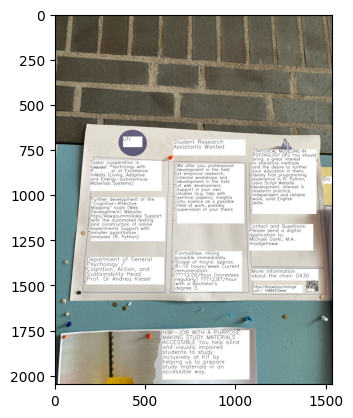

In [204]:
plt.imshow(img_rgb)

In [205]:
cv2.imwrite("translated.jpeg",img_rgb)

True